In [ ]:
import torch
from ultralytics import YOLO
from ultralytics import settings
import wandb
from pathlib import Path

settings.update({'wandb': True})
print(f"W&B enabled: {settings['wandb']}")

wandb.login(relogin=False)

device = [2, 3, 4, 5,6,7]  # 6 GPUs
print(f"Using GPUs: {device}")


if torch.cuda.is_available():
    total_gpus = torch.cuda.device_count()
    print(f"Total GPUs detected by PyTorch: {total_gpus}")
    
    # Filter device list to only include valid GPU indices
    device = [gpu_id for gpu_id in device if gpu_id < total_gpus]
    print(f"Valid GPUs to use: {device}")
    
    for gpu_id in device:
        print(f"  GPU {gpu_id}: {torch.cuda.get_device_name(gpu_id)}")
else:
    print("CUDA not available, using CPU")
    device = 'cpu'

# 3. Configuration (Cross-platform paths)
BASE_DIR = Path.cwd()  # Gets the current working directory
DATA_YAML = str(BASE_DIR / 'yolov11_dataset' / 'data.yaml')
PROJECT_NAME = 'BDD100K_YOLOv11'

print(f"Data YAML: {DATA_YAML}")

W&B enabled: True


wandb: Currently logged in as: akash012 (akash012-iit-mandi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using GPUs: 0
Total GPUs detected by PyTorch: 1
Data YAML: d:\bdd100k\yolov11_dataset\data.yaml


#### 1. dataset and labels
 


Checking training data...
Looking for images in: /usershome/varun/akash_singh/bdd100k/yolov11_dataset/train/images


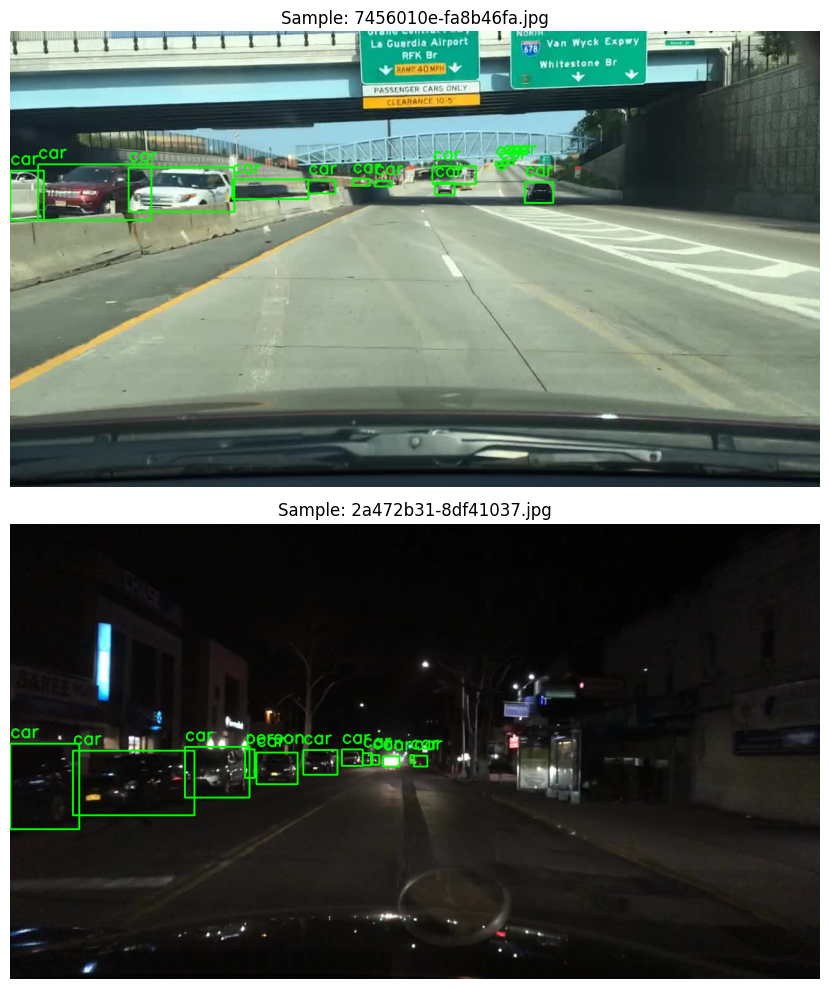

In [ ]:

import cv2
import matplotlib.pyplot as plt
import random
import yaml
def plot_sample_data(data_yaml_path, split='train', num_samples=1):
    
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    base_path = Path(data_yaml_path).parent
    img_dir = base_path / data_config[split]

    if not img_dir.exists():
        
        img_dir = base_path / data_config[split]
        
    if not img_dir.exists():
        img_dir = base_path / split / 'images'

    print(f"Looking for images in: {img_dir}")
    
    if not img_dir.exists():
        print(f"Error: Image directory not found : {img_dir}")
        return

    # Get all images
    image_files = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
    
    if not image_files:
        print("No images found.")
        return
        
    # Class names
    names = data_config['names']
    
    # Plot samples
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        img_file = random.choice(image_files)
        label_file = img_file.parent.parent / 'labels' / img_file.with_suffix('.txt').name
        
        # Read image
        img = cv2.imread(str(img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Read labels
        if label_file.exists():
            with open(label_file, 'r') as f:
                labels = f.readlines()
                
            for label in labels:
                class_id, x_center, y_center, width, height = map(float, label.split())
                
                # Convert YOLO format to pixels
                x1 = int((x_center - width/2) * w)
                y1 = int((y_center - height/2) * h)
                x2 = int((x_center + width/2) * w)
                y2 = int((y_center + height/2) * h)
                
                # Draw box
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # Draw label
                class_name = names[int(class_id)]
                cv2.putText(img, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        else:
            print(f"No label file found for {img_file.name}")
            
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Sample: {img_file.name}")
        
    plt.tight_layout()
    plt.show()

# Run the check
print("Checking training data...")
plot_sample_data(DATA_YAML, split='train', num_samples=2)

#### 2. Full Training on 100% dataset

In [ ]:

image_sizes = [640, 1280]

EPOCHS = 100
PATIENCE = 15


BATCH_SIZE = 96  # 16 per GPU x 6 GPUs = 96

# Linear scaling
LR0 = 0.015 


for size in image_sizes:
    run_name = f'{PROJECT_NAME}_img{size}_lr{LR0}_cos'
    print(f"\n{'='*40}\nStarting Run: {run_name}\n{'='*40}")
    
    # 1. Initialize W&B 
    run = wandb.init(
        project=PROJECT_NAME,
        name=run_name,
        config={
            "imgsz": size,
            "batch_size": BATCH_SIZE,
            "model": "yolo11s.pt",
            "epochs": EPOCHS,
            "patience": PATIENCE,
            "lr0": LR0,
            "cos_lr": True,
            "warmup_epochs": 0,
            "amp": True,
        },
        reinit=True
    )
    
    try:
        # 2. Train
        model = YOLO('yolo11s.pt') 
        
        model.train(
            data=DATA_YAML,
            project=PROJECT_NAME,
            name=run_name,
            epochs=EPOCHS,             
            imgsz=size,            
            batch=BATCH_SIZE,      
            fraction=1.0,          
            device=device,
            patience=PATIENCE,            
            optimizer='auto',
            lr0=LR0,
            cos_lr=True,
            warmup_epochs=0,
            amp=True,
            weight_decay=0.0005,
            momentum=0.937,
            exist_ok=True,
            verbose=True,
            save=True,              
            plots=True
        )
        
        # Test 
        print(f"\nRunning Quantitative Test Evaluation for {run_name}...")
        best_model_path = str(BASE_DIR / PROJECT_NAME / run_name / 'weights' / 'best.pt')
        best_model = YOLO(best_model_path)
        
        test_metrics = best_model.val(
            data=DATA_YAML,
            split='test',      
            imgsz=size,
            device=device,
            conf=0.001,
            iou=0.6,
            rect=True,
            name=f'{run_name}_test',
            plots=True
        )
        
        # F1 Score 
        mp = test_metrics.box.mp
        mr = test_metrics.box.mr
        f1_score = 2 * (mp * mr) / (mp + mr + 1e-16)
        
        # W&B
        wandb.log({
            "test/mAP50": test_metrics.box.map50,
            "test/mAP50-95": test_metrics.box.map,
            "test/precision": mp,
            "test/recall": mr,
            "test/f1_score": f1_score
        })
        print(f"Test metrics (including F1: {f1_score:.4f}) logged for {run_name}")

        # Visual
        print(f"\nRunning Visual Inference on sample test images...")
        test_images_dir = BASE_DIR / 'yolov11_dataset' / 'test' / 'images'
        sample_images = list(test_images_dir.glob('*.jpg'))[:10]
        
        if sample_images:
            results = best_model.predict(
                sample_images,
                imgsz=size,
                device=device,
                conf=0.25,
                iou=0.45
            )
            
            wandb_images = []
            for res in results:
                im_array = res.plot()
                im_array = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
                wandb_images.append(wandb.Image(im_array, caption=f"Pred: {res.path}"))
            
            wandb.log({"test/visual_predictions": wandb_images})
            print(f"Visual predictions logged to W&B")

    except Exception as e:
        print(f"Run Error {run_name}: {e}")
    
    finally:
        run.finish()


Starting Run: BDD100K_YOLOv11_img640_lr0.015_cos


Ultralytics 8.3.237 🚀 Python-3.10.19 torch-2.9.1+cu126 CUDA:2 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:3 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:4 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:5 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:6 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:7 (NVIDIA RTX A6000, 48539MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=96, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/usershome/varun/akash_singh/bdd100k/yolov11_dataset/data.yaml, degrees=0.0, deterministic=True, device=2,3,4,5,6,7, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epoch

wandb: Currently logged in as: akash012 (akash012-iit-mandi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: setting up run yyrq8r1j
wandb: Tracking run with wandb version 0.23.1
wandb: Run data is saved locally in /usershome/varun/akash_singh/bdd100k/wandb/run-20251214_124529-yyrq8r1j
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run BDD100K_YOLOv11_img640_lr0.015_cos
wandb: ⭐️ View project at https://wandb.ai/akash012-iit-mandi/BDD100K_YOLOv11
wandb: 🚀 View run at https://wandb.ai/akash012-iit-mandi/BDD100K_YOLOv11/runs/yyrq8r1j


Overriding model.yaml nc=80 with nc=7
Transferred 493/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 975.5±322.2 MB/s, size: 55.1 KB)
train: Scanning /usershome/varun/akash_singh/bdd100k/yolov11_dataset/train/labels.cache... 2679 images, 15 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2679/2679 9.8Mit/s 0.0s0s
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1235.2±393.3 MB/s, size: 55.9 KB)
val: Scanning /usershome/varun/akash_singh/bdd100k/yolov11_dataset/valid/labels.cache... 500 images, 5 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 500/500 435.6Kit/s 0.0s
Plotting labels to /usershome/varun/akash_singh/bdd100k/BDD100K_YOLOv11/BDD100K_YOLOv11_img640_lr0.015_cos/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.015' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer

wandb: WARNING Tried to log to step 93 that is less than the current step 94. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: updating run metadata; uploading artifact run-yyrq8r1j-curvesPrecision-ConfidenceB_table-bdLOeQ; uploading media/table/curves/F1-Confidence(B)_table_95_fa73c85522f3dbeade4a.table.json; uploading media/table/curves/Precision-Confidence(B)_table_95_85d474a7845c352b4dc5.table.json; uploading artifact run-yyrq8r1j-curvesRecall-ConfidenceB_table-P6ij3g
wandb: uploading artifact run-yyrq8r1j-curvesRecall-ConfidenceB_table-P6ij3g; uploading output.log; uploading wandb-summary.json; uploading media/table/curves/Recall-Confidence(B)_table_95_34e728a8c4760ddb3d35.table.json
wandb: uploading output.log; uploading config.yaml
wandb: uploading history steps 93-93, summary
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
wandb:          


Running Quantitative Test Evaluation for BDD100K_YOLOv11_img640_lr0.015_cos...
Ultralytics 8.3.237 🚀 Python-3.10.19 torch-2.9.1+cu126 CUDA:2 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:3 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:4 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:5 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:6 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:7 (NVIDIA RTX A6000, 48539MiB)
YOLO11s summary (fused): 100 layers, 9,415,509 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1588.6±755.3 MB/s, size: 48.9 KB)
val: Scanning /usershome/varun/akash_singh/bdd100k/yolov11_dataset/test/labels.cache... 1000 images, 8 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1000/1000 1.0Mit/s 0.0ss
                 Class     Images  I

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


✅ Visual predictions logged to W&B


test/f1_score,▁
test/mAP50,▁
test/mAP50-95,▁
test/precision,▁
test/recall,▁
test/f1_score,0.43884
test/mAP50,0.36283
test/mAP50-95,0.20737
test/precision,0.5872
test/recall,0.35033



Starting Run: BDD100K_YOLOv11_img1280_lr0.015_cos


Ultralytics 8.3.237 🚀 Python-3.10.19 torch-2.9.1+cu126 CUDA:2 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:3 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:4 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:5 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:6 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:7 (NVIDIA RTX A6000, 48539MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=96, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/usershome/varun/akash_singh/bdd100k/yolov11_dataset/data.yaml, degrees=0.0, deterministic=True, device=2,3,4,5,6,7, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epoch

wandb: Currently logged in as: akash012 (akash012-iit-mandi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: setting up run g1hnicyg
wandb: Tracking run with wandb version 0.23.1
wandb: Run data is saved locally in /usershome/varun/akash_singh/bdd100k/wandb/run-20251214_125301-g1hnicyg
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run BDD100K_YOLOv11_img1280_lr0.015_cos
wandb: ⭐️ View project at https://wandb.ai/akash012-iit-mandi/BDD100K_YOLOv11
wandb: 🚀 View run at https://wandb.ai/akash012-iit-mandi/BDD100K_YOLOv11/runs/g1hnicyg


Overriding model.yaml nc=80 with nc=7
Transferred 493/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1037.9±267.5 MB/s, size: 55.1 KB)
train: Scanning /usershome/varun/akash_singh/bdd100k/yolov11_dataset/train/labels.cache... 2679 images, 15 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2679/2679 12.1Mit/s 0.0ss
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 932.2±469.6 MB/s, size: 55.9 KB)
val: Scanning /usershome/varun/akash_singh/bdd100k/yolov11_dataset/valid/labels.cache... 500 images, 5 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 500/500 454.1Kit/s 0.0s
Plotting labels to /usershome/varun/akash_singh/bdd100k/BDD100K_YOLOv11/BDD100K_YOLOv11_img1280_lr0.015_cos/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.015' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimize

wandb: updating run metadata; uploading media/table/curves/F1-Confidence(B)_table_91_11b47ad011271c55922d.table.json; uploading artifact run-g1hnicyg-curvesPrecision-ConfidenceB_table-YocQIg; uploading media/table/curves/Precision-Confidence(B)_table_91_ac921364cafb333351e3.table.json; uploading artifact run-g1hnicyg-curvesRecall-ConfidenceB_table-dNitaA
wandb: uploading artifact run-g1hnicyg-curvesRecall-ConfidenceB_table-dNitaA; uploading media/table/curves/Recall-Confidence(B)_table_91_bb5bd73feb5c15be0047.table.json; uploading output.log; uploading wandb-summary.json
wandb: uploading media/table/curves/Recall-Confidence(B)_table_91_bb5bd73feb5c15be0047.table.json; uploading output.log; uploading wandb-summary.json; uploading config.yaml
wandb: uploading config.yaml
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
wandb:                  lr/pg2 ████████▇▇▇▇▇▇▇▆▆


Running Quantitative Test Evaluation for BDD100K_YOLOv11_img1280_lr0.015_cos...
Ultralytics 8.3.237 🚀 Python-3.10.19 torch-2.9.1+cu126 CUDA:2 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:3 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:4 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:5 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:6 (NVIDIA RTX A6000, 48539MiB)
                                                       CUDA:7 (NVIDIA RTX A6000, 48539MiB)
YOLO11s summary (fused): 100 layers, 9,415,509 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1303.2±553.2 MB/s, size: 48.9 KB)
val: Scanning /usershome/varun/akash_singh/bdd100k/yolov11_dataset/test/labels.cache... 1000 images, 8 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1000/1000 1.1Mit/s 0.0ss
                 Class     Images  

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


✅ Visual predictions logged to W&B


test/f1_score,▁
test/mAP50,▁
test/mAP50-95,▁
test/precision,▁
test/recall,▁
test/f1_score,0.47484
test/mAP50,0.40153
test/mAP50-95,0.22662
test/precision,0.63201
test/recall,0.38028
